# Прогнозирование заказов такси 

In [1]:
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import time
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
import warnings
warnings.simplefilter('ignore')
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
# Изменим тип данных в столбце datetime
df['datetime'] = df['datetime'].apply(pd.to_datetime)

In [7]:
# Установим индекс таблицы равным столбцу datetime
df = df.set_index('datetime')

In [8]:
# Посмотрим атрибут индекса таблицы is_monotonic, чтобы проверить,
# в хронологическом ли порядке расположены даты и время  
df.index.is_monotonic

True

Даты и время расположены в хронологическом порядке. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


У нас есть данные с 1-го марта 2018 года по 31-ое августа этого же года. 

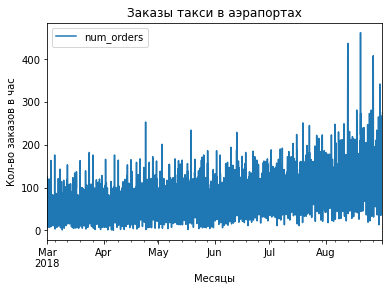

In [10]:
# Выполним ресемплирование данных по одному часу
df = df.resample('1H').sum()
df.plot()
plt.title('Заказы такси в аэрапортах')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов в час')
plt.show()

Из графика ничего непонятно. Лучше выбрать более короткий промежуток для рассмотрения, возьмем последнюю неделю августа.  

<AxesSubplot:xlabel='datetime'>

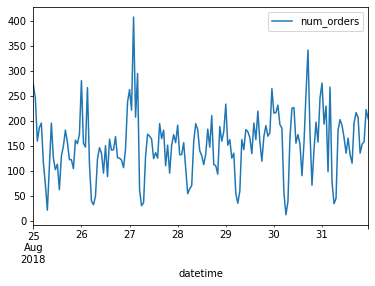

In [11]:
# Посмотрим на неделю 
srez = df['2018-08-25':'2018-08-31']
srez.plot()

Все равно много колебаний. Из графика ничего не понятно. Разложим на тренд и сезонную компоненту. 

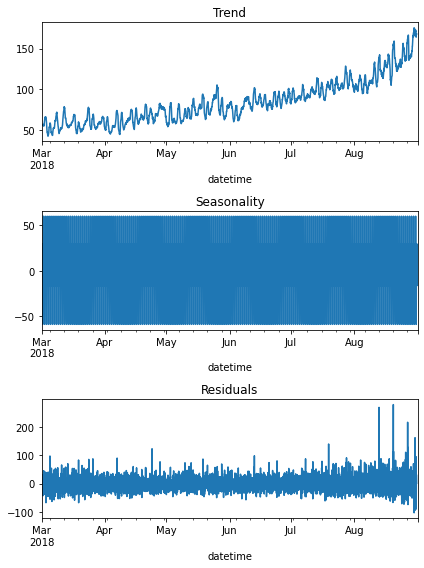

In [12]:
# Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд показывает рост заказов с мая. К сожалению сезонность слишком плотная на таком графике, лучше использовать более короткий период для рассмотрения. 

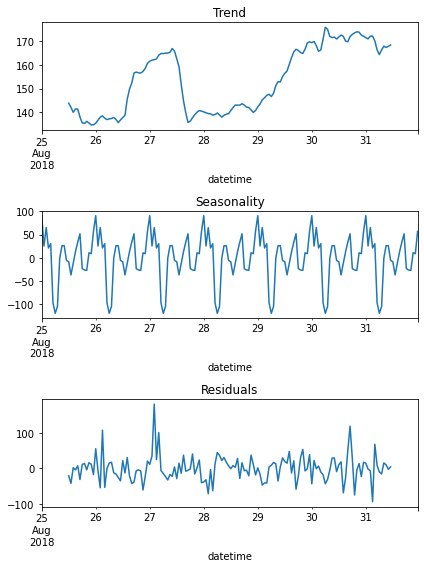

In [13]:
# Разложим временной ряд последней недели агуста на тренд и сезонную компоненту 
decomposed = seasonal_decompose(df['2018-08-25':'2018-08-31']) 

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Теперь мы хорошо видим сезонность, стоит рассмотреть на примере двух дней. 

<AxesSubplot:xlabel='datetime'>

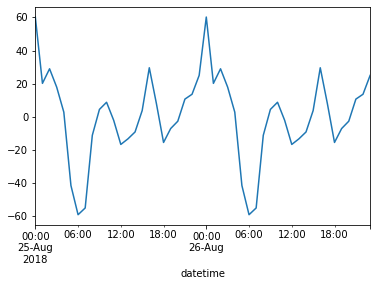

In [14]:
# Посмотрим на сезонную компоненту двух дней. 
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-08-25':'2018-08-26'].plot()

Мы наблюдаем рост тренда за последние 3 дня, соотвественно кол-во заказов растет. Сезонность показывает нам, что ранним утром, в районе 06.00 утра кол-во заказов минимальное, а в промежутке с 18.00 наблюдается постепенный рост заказов вплоть до полуночи, затем снижение до 06.00 утра. 

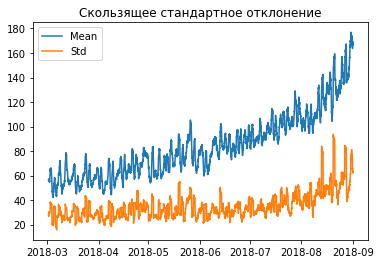

In [15]:
# Найдём скользящее стандартное отклонение
qw = df['num_orders'].rolling(24).mean()
er = df['num_orders'].rolling(24).std()
fig, ax = plt.subplots()
ax.plot(qw, label='Mean') 
ax.plot(er, label='Std')
plt.title('Скользящее стандартное отклонение')
plt.legend()
plt.show() 

In [16]:
from statsmodels.tsa.stattools import adfuller

ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Прогнозирование 

In [17]:
# Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    
    df['dayofweek'] = df.index.dayofweek
    
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)


    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
# Разделим выборку на обучающую и тестовую (тестовая составит 10% от исходных данных).
make_features(df, 24, 48)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

# Проверим корректность деления 
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
print(train.shape)
print(test.shape)

2018-03-03 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00
(3926, 28)
(442, 28)


In [19]:
# объявим переменные features и target для каждой выборки
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [20]:
# функция для вычисления rmse
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    difference = predict - actual
    square_diff = np.square(difference)
    mean_square_diff = square_diff.mean()
    score = np.sqrt(mean_square_diff)
    return score

In [21]:
# Для тестирования моделей кросс-валидацией необходимо создать собственный scorer, который будет высчитывать RMSE.
rmse_score = make_scorer(rmse, greater_is_better = False)

In [22]:
tscv = TimeSeriesSplit(n_splits=10)

### RandomForestRegressor

In [23]:
%%time
model = RandomForestRegressor()
params = { 'n_estimators': range(10,15,1),
          'min_samples_leaf': range(1,6,2)}
model_rfr = RandomizedSearchCV(model, params, verbose=5, scoring=rmse_score, cv=tscv, n_jobs=-1, random_state=12345)
model_rfr.fit(features_train, target_train) 
print(model_rfr.best_score_)
print(model_rfr.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
-24.584780099786467
{'n_estimators': 12, 'min_samples_leaf': 3}
CPU times: user 1.03 s, sys: 324 ms, total: 1.36 s
Wall time: 6.49 s


### LinearRegression

In [24]:
%%time
model = LinearRegression()
params = { 'fit_intercept': ['True', 'False']}

model_lr = RandomizedSearchCV(model, params, verbose=5, scoring=rmse_score, cv=tscv, n_jobs=-1)
model_lr.fit(features_train, target_train) 
print(model_lr.best_score_)
print(model_lr.best_params_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
-26.576380667585575
{'fit_intercept': 'True'}
CPU times: user 73.4 ms, sys: 16.1 ms, total: 89.5 ms
Wall time: 101 ms


### CatBoostRegressor

In [25]:
%%time
model = CatBoostRegressor()
params = {'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[12345],
                'verbose':[False]}

model_CBR = RandomizedSearchCV(model, params, verbose=5, scoring=rmse_score, cv=tscv, n_jobs=-1)
model_CBR.fit(features_train, target_train) 
print(model_CBR.best_score_)
print(model_CBR.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
-23.524294849767465
{'verbose': False, 'random_state': 12345, 'learning_rate': 0.1}
CPU times: user 6.18 s, sys: 1.51 s, total: 7.69 s
Wall time: 23.7 s


### LGBMRegressor

In [26]:
%%time
model = LGBMRegressor() 
params = {'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[12345]}
model_LGBM = RandomizedSearchCV(model, params, verbose=5, scoring=rmse_score, cv=tscv, n_jobs=-1)
model_LGBM.fit(features_train, target_train) 
print(model_LGBM.best_score_)
print(model_LGBM.best_params_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
-24.038078396849393
{'random_state': 12345, 'learning_rate': 0.1}
CPU times: user 916 ms, sys: 91.8 ms, total: 1.01 s
Wall time: 2.43 s


In [27]:
# Лучший показатель у модели CatBoostRegressor. Проверим  rmse на тестовой выборке. 
pred_CBR = model_CBR.predict(features_test)
rmse_CBR = rmse(target_test, pred_CBR)
rmse_CBR

40.37319006187771

### Проверка на адекватность

In [28]:
model_dr = DummyRegressor().fit(features_train, target_train)
pred_dr = model_dr.predict(features_test)
rmse_dr = rmse(target_test, pred_dr)
rmse_dr

84.5807770460722

[CV 5/10] END min_samples_leaf=1, n_estimators=10;, score=-24.138 total time=   0.3s
[CV 4/10] END min_samples_leaf=5, n_estimators=11;, score=-22.255 total time=   0.2s
[CV 9/10] END min_samples_leaf=5, n_estimators=11;, score=-29.929 total time=   0.4s
[CV 1/10] END min_samples_leaf=3, n_estimators=13;, score=-19.686 total time=   0.1s
[CV 4/10] END min_samples_leaf=3, n_estimators=13;, score=-22.288 total time=   0.2s
[CV 10/10] END min_samples_leaf=3, n_estimators=13;, score=-33.395 total time=   0.6s
[CV 3/10] END min_samples_leaf=3, n_estimators=11;, score=-25.248 total time=   0.2s
[CV 7/10] END min_samples_leaf=3, n_estimators=11;, score=-24.703 total time=   0.4s
[CV 6/10] END min_samples_leaf=5, n_estimators=12;, score=-23.802 total time=   0.3s
[CV 6/10] END min_samples_leaf=5, n_estimators=10;, score=-22.939 total time=   0.2s
[CV 4/10] END min_samples_leaf=5, n_estimators=14;, score=-22.410 total time=   0.2s
[CV 10/10] END min_samples_leaf=5, n_estimators=14;, score=-32.9

# Вывод
Нами были получены данные о заказах такси в аэропортах за пол года: с 1-го марта по 31-ое августа 2018 года. С мая наблюдается рост кол-ва заказов, скорее всего связано с сезонностью отпусков. Что касается кол-ва заказов по дню, то здесь наблюдается следующая тенденция: кол-во заказов растет с утра до полуночи, затем постепенно снижается. Самое малое кол-во заказов наблюдается в районе 6 утра.
Перед нами стояла задача построить модель для предсказания кол-ва заказов такси на следующий час. 
Мы обучили несколько моделей, самый лучший показатель дала модель CatBoostRegressor, но не самый быстрый. Проверив ее на тестовой выборке получили неплохой результат. 